### 100,000 UK Used Car Data set
https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes


1. Выбрать набор данных для своей группы: <br>
    3530203_70301: Mercedes<br>
    3530203_70302: Ford <br>
    3530903_70101: BMW <br>
    3530903_70102: Audi <br>
    
2. Разбить данные на тренировочные и тестовые (70% на 30%, random_state=10).
3. Применить доступные способы предобработки данных.
4. Попытаться обучить регрессию для предсказания цены автомобиля c наилучшим качеством. Качество оценивать по метрике RMSE на тестовой подвыборке. Попробовать различные модели регуляризации (и не только).


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split


In [114]:
auto_data = pd.read_csv("bmw.csv")
auto_data

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0
...,...,...,...,...,...,...,...,...,...
10776,X3,2016,19000,Automatic,40818,Diesel,150,54.3,2.0
10777,5 Series,2016,14600,Automatic,42947,Diesel,125,60.1,2.0
10778,3 Series,2017,13100,Manual,25468,Petrol,200,42.8,2.0
10779,1 Series,2014,9930,Automatic,45000,Diesel,30,64.2,2.0


## Data preprocessing

In [5]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB


Нет null значений

In [6]:
auto_data.describe()

,year,price,mileage,tax,mpg,engineSize
count,10781.000000,10781.000000,10781.000000,10781.000000,10781.000000,10781.000000
mean,2017.078935,22733.408867,25496.986550,131.702068,56.399035,2.167767
std,2.349038,11415.528189,25143.192559,61.510755,31.336958,0.552054
min,1996.000000,1200.000000,1.000000,0.000000,5.500000,0.000000
25%,2016.000000,14950.000000,5529.000000,135.000000,45.600000,2.000000
50%,2017.000000,20462.000000,18347.000000,145.000000,53.300000,2.000000
75%,2019.000000,27940.000000,38206.000000,145.000000,62.800000,2.000000
max,2020.000000,123456.000000,214000.000000,580.000000,470.800000,6.600000


* `year` -- реалистично
* `price=1200` -- неправдоподобно
* `price=123456` -- надо проверить
* `mpg=470.8` -- вероятно выброс (кол-во миль на галон)
* `mileage=1` -- реалистичный пробег, машина с завода
* `tax=0` -- наверное, корректное значение
* `engineSize=0` -- пустое значение
* `engineSize=6.6` -- реалистично, проверили, есть, например, у BMW 7-series

In [115]:
zero_engine = auto_data[auto_data['engineSize'] == 0]
len(zero_engine)

47

In [119]:
auto_data.drop(zero_engine.index, inplace=True)

In [116]:
max_engine = auto_data[auto_data['engineSize'] == 6.6]
max_engine

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
9585,7 Series,2017,52950,Automatic,22000,Petrol,150,22.1,6.6
9799,7 Series,2017,57000,Automatic,11297,Petrol,145,22.1,6.6


Все хорошо, у этой модели есть такой модели есть такой объем двигателя

In [120]:
auto_data_max_price = auto_data[auto_data['price'] > 80000.0]
auto_data_max_price

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
721,8 Series,2019,84898,Semi-Auto,3185,Petrol,145,24.4,4.4
1813,8 Series,2019,88980,Semi-Auto,88,Petrol,145,24.4,4.4
2909,M4,2017,89990,Semi-Auto,1336,Petrol,145,33.2,3.0
4776,M5,2019,89900,Semi-Auto,2269,Petrol,145,24.1,4.4
5362,M4,2016,99950,Automatic,771,Petrol,300,33.2,3.0
5877,M5,2019,81140,Semi-Auto,551,Petrol,145,24.1,4.4


123456 - это **выброс** исходя из ее характеристик

In [121]:
auto_data_price = auto_data[auto_data['price'] == 123456.0]
auto_data.drop(auto_data_price.index, inplace=True)

In [122]:
auto_data_min_price = auto_data[auto_data['price'] == 1200.0]
auto_data_min_price

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
9744,3 Series,1999,1200,Automatic,82000,Petrol,245,31.0,2.8


Исходя из характеристик, считаем, что цена оправдана

In [123]:
auto_data_mpg = auto_data[auto_data['mpg'] > 400.0]
auto_data_mpg

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
32,i3,2016,17100,Automatic,25269,Other,0,470.8,0.6
8188,i3,2015,14940,Automatic,59000,Other,0,470.8,0.6
8620,i3,2017,19300,Automatic,32867,Other,0,470.8,0.6
8835,i3,2015,17400,Automatic,29465,Electric,0,470.8,1.0
10080,i3,2017,20000,Automatic,19178,Other,0,470.8,0.6
10086,i3,2017,19500,Automatic,23956,Other,135,470.8,0.6
10325,i3,2016,17000,Automatic,41063,Other,0,470.8,0.6
10530,i3,2017,17600,Automatic,50867,Other,135,470.8,0.6


Проверено, все сходится https://www.honestjohn.co.uk/realmpg/bmw/i3-2013

<AxesSubplot:>

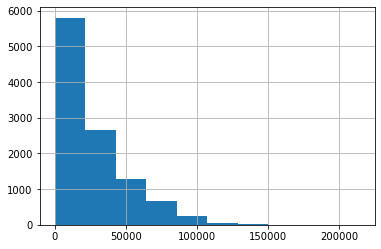

In [73]:
auto_data.mileage.hist()

Распределение выглядит реалистично

In [79]:
auto_data.describe()

,year,price,mileage,tax,mpg,engineSize
count,10733.000000,10733.000000,10733.000000,10733.000000,10733.000000,10733.000000
mean,2017.083388,22742.889313,25482.101556,131.996646,55.040622,2.177276
std,2.347757,11392.304903,25176.765334,61.133010,20.598474,0.534279
min,1996.000000,1200.000000,1.000000,0.000000,5.500000,0.600000
25%,2016.000000,14950.000000,5500.000000,135.000000,45.600000,2.000000
50%,2017.000000,20490.000000,18271.000000,145.000000,53.300000,2.000000
75%,2019.000000,27950.000000,38231.000000,145.000000,62.800000,2.000000
max,2020.000000,99950.000000,214000.000000,580.000000,470.800000,6.600000


In [124]:
fueltype_counts = auto_data.fuelType.value_counts()
fueltype_counts

Diesel      7017
Petrol      3414
Hybrid       265
Other         36
Electric       1
Name: fuelType, dtype: int64

C:\ProgramData\Anaconda3\envs\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='fuelType', ylabel='count'>

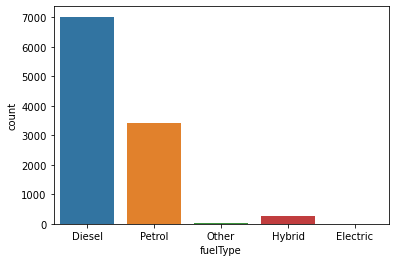

In [125]:
sns.countplot(auto_data.fuelType)

In [82]:
hybrids = auto_data[auto_data.fuelType == 'Hybrid']
set(hybrids.model)

{' 2 Series', ' 3 Series', ' 5 Series', ' 7 Series', ' X3', ' X5', ' i8'}

Да, они действительно бывают гибридными

In [104]:
other = auto_data[auto_data.fuelType == 'Other']
set(other.model)

{' 2 Series', ' 3 Series', ' 5 Series', ' X5', ' i3', ' i8'}

## Линейная регрессия

### LinearRegression()

In [126]:
from sklearn.preprocessing import LabelEncoder

string_cols = ("model", "transmission", "fuelType")
auto_data_with_labels = auto_data.copy()

for col in string_cols:
    lbl = LabelEncoder()
    lbl.fit(list(auto_data_with_labels[col].values))
    auto_data_with_labels[col] = lbl.transform(list(auto_data_with_labels[col].values))

auto_data_with_labels

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,4,2014,11200,0,67068,0,125,57.6,2.0
1,5,2018,27000,0,14827,4,145,42.8,2.0
2,4,2016,16000,0,62794,0,160,51.4,3.0
3,0,2017,12750,0,26676,0,145,72.4,1.5
4,6,2014,14500,0,39554,0,160,50.4,3.0
...,...,...,...,...,...,...,...,...,...
10776,15,2016,19000,0,40818,0,150,54.3,2.0
10777,4,2016,14600,0,42947,0,125,60.1,2.0
10778,2,2017,13100,1,25468,4,200,42.8,2.0
10779,0,2014,9930,0,45000,0,30,64.2,2.0


In [143]:
auto_data_with_labels_without_price = auto_data_with_labels.drop(['price'], axis=1)
auto_data_with_labels_without_price

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
0,4,2014,0,67068,0,125,57.6,2.0
1,5,2018,0,14827,4,145,42.8,2.0
2,4,2016,0,62794,0,160,51.4,3.0
3,0,2017,0,26676,0,145,72.4,1.5
4,6,2014,0,39554,0,160,50.4,3.0
...,...,...,...,...,...,...,...,...
10776,15,2016,0,40818,0,150,54.3,2.0
10777,4,2016,0,42947,0,125,60.1,2.0
10778,2,2017,1,25468,4,200,42.8,2.0
10779,0,2014,0,45000,0,30,64.2,2.0


In [144]:
X, Y = auto_data_with_labels_without_price, auto_data_with_labels['price']

In [145]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [146]:
std_scaler = StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

X_train_scaled

array([[-0.53800592,  0.8235433 , -1.25994531, ...,  0.21680382,
        -0.30856817, -0.33026795],
       [-0.70564884, -1.30048032, -0.10962703, ..., -0.10997863,
         0.17707954, -0.33026795],
       [-0.87329176,  1.24834803,  1.04069125, ...,  0.21680382,
        -0.30856817, -0.33026795],
       ...,
       [-0.87329176,  1.24834803,  1.04069125, ...,  0.21680382,
         0.11994451, -1.26301853],
       [-0.53800592,  1.24834803,  1.04069125, ...,  0.21680382,
        -0.34665819,  1.53523322],
       [ 1.30606621, -0.02606615,  1.04069125, ...,  0.46189066,
        -0.494257  , -0.33026795]])

In [147]:
simple_LR = LinearRegression()

simple_LR.fit(X_train_scaled, Y_train)
simple_LR_predictions = simple_LR.predict(X_test_scaled)

simple_LR_MSE = metrics.mean_squared_error(Y_test, simple_LR_predictions)

print (f'MSE = {round(simple_LR_MSE,3)}')

MSE = 30371783.093


In [148]:
simple_LR_RMSE = metrics.mean_squared_error(Y_test, simple_LR_predictions, squared = False)

print (f'RMSE = {round(simple_LR_RMSE,3)}')

RMSE = 5511.06


In [149]:
print (f'Test std: {round(Y_test.std(),3)}')

Test std: 11338.271


Text(0, 0.5, 'Target')

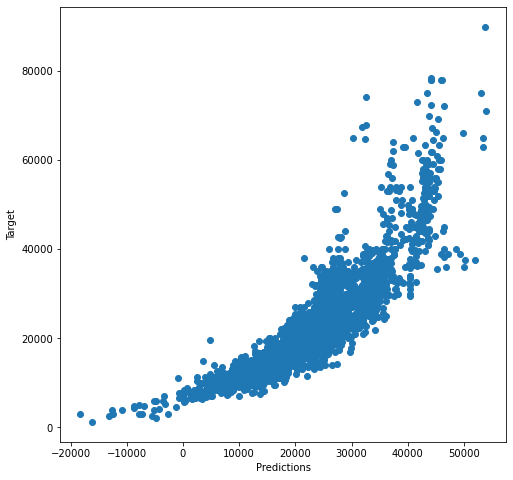

In [150]:
plt.figure(figsize=(8, 8))
plt.scatter(simple_LR_predictions, Y_test)
plt.xlabel('Predictions')
plt.ylabel('Target')

In [151]:
simple_LR.intercept_, simple_LR.coef_

(22644.487288699733,
 array([ 3552.12364701,  4640.15704182,   242.05706693, -2852.46471913,
          621.51151279,  -801.1898991 ,  -290.02566514,  4754.09057115]))

In [153]:
pd.DataFrame(simple_LR.coef_, auto_data_with_labels_without_price.columns, columns=['Coefficients'])

,Coefficients
model,3552.123647
year,4640.157042
transmission,242.057067
mileage,-2852.464719
fuelType,621.511513
tax,-801.189899
mpg,-290.025665
engineSize,4754.090571


### Lasso()

In [154]:
model = Lasso()

model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

print (f'RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(simple_LR.coef_,  auto_data_with_labels_without_price.columns, columns=['Coefficients'])

RMSE = 5511.097


,Coefficients
model,3552.123647
year,4640.157042
transmission,242.057067
mileage,-2852.464719
fuelType,621.511513
tax,-801.189899
mpg,-290.025665
engineSize,4754.090571


### LassoCV()

In [155]:
model = LassoCV()

model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

print (f'RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(simple_LR.coef_,  auto_data_with_labels_without_price.columns, columns=['Coefficients'])

RMSE = 5511.353


,Coefficients
model,3552.123647
year,4640.157042
transmission,242.057067
mileage,-2852.464719
fuelType,621.511513
tax,-801.189899
mpg,-290.025665
engineSize,4754.090571


### LassoCV() with alphas

In [156]:
alphas = np.linspace(1, 10, 20)
alphas

array([ 1.        ,  1.47368421,  1.94736842,  2.42105263,  2.89473684,
        3.36842105,  3.84210526,  4.31578947,  4.78947368,  5.26315789,
        5.73684211,  6.21052632,  6.68421053,  7.15789474,  7.63157895,
        8.10526316,  8.57894737,  9.05263158,  9.52631579, 10.        ])

In [158]:
model = LassoCV(random_state = 10, alphas=alphas)

model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

print (f'RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(simple_LR.coef_,  auto_data_with_labels_without_price.columns, columns=['Coefficients'])

RMSE = 5511.227


,Coefficients
model,3552.123647
year,4640.157042
transmission,242.057067
mileage,-2852.464719
fuelType,621.511513
tax,-801.189899
mpg,-290.025665
engineSize,4754.090571


### Ridge()

In [159]:
model = Ridge()

model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

print (f'RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(simple_LR.coef_,  auto_data_with_labels_without_price.columns, columns=['Coefficients'])

RMSE = 5511.088


,Coefficients
model,3552.123647
year,4640.157042
transmission,242.057067
mileage,-2852.464719
fuelType,621.511513
tax,-801.189899
mpg,-290.025665
engineSize,4754.090571


### RidgeCV()

In [160]:
model = RidgeCV()

model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

print (f'RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(simple_LR.coef_,  auto_data_with_labels_without_price.columns, columns=['Coefficients'])

RMSE = 5511.344


,Coefficients
model,3552.123647
year,4640.157042
transmission,242.057067
mileage,-2852.464719
fuelType,621.511513
tax,-801.189899
mpg,-290.025665
engineSize,4754.090571


### RandomForestRegressor

In [162]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state = 10, n_estimators = 100)

model.fit(X_train, Y_train)
predictions = model.predict(X_test)

print (f'RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(model.feature_importances_, auto_data_with_labels_without_price.columns,
             columns=['Importance']).sort_values('Importance')

RMSE = 2317.379


,Importance
fuelType,0.003866
transmission,0.005195
tax,0.011875
mpg,0.046620
mileage,0.072908
model,0.145542
engineSize,0.261630
year,0.452363


Text(0, 0.5, 'Target')

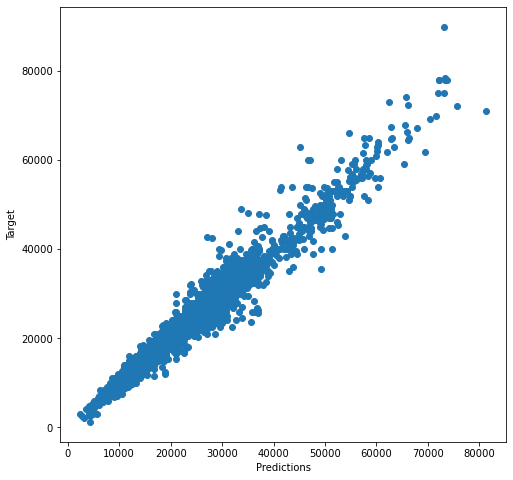

In [163]:
plt.figure(figsize=(8, 8))
plt.scatter(predictions, Y_test)
plt.xlabel('Predictions')
plt.ylabel('Target')